In [ ]:
#!/usr/bin/env python3
"""
Usage:
  python sanitize_notebook.py in_notebook.ipynb out_notebook.ipynb

This removes metadata.widgets entries from the notebook and from each cell's metadata.
"""
import sys
import nbformat

def sanitize(infile, outfile):
    """Removes metadata.widgets entries from a notebook file."""
    try:
        with open(infile, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)
    except FileNotFoundError:
        print(f"Error: Input file not found at {infile}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"Error reading input notebook {infile}: {e}", file=sys.stderr)
        sys.exit(1)

    if 'widgets' in nb.get('metadata', {}):
        del nb['metadata']['widgets']
    for cell in nb.get('cells', []):
        if 'widgets' in cell.get('metadata', {}):
            del cell['metadata']['widgets']

    try:
        with open(outfile, 'w', encoding='utf-8') as f:
            nbformat.write(nb, f)
    except Exception as e:
        print(f"Error writing output notebook to {outfile}: {e}", file=sys.stderr)
        sys.exit(1)


if __name__ == '__main__':
    # This script is intended to be run from the command line.
    # When run directly in a notebook cell, sys.argv will contain extra arguments
    # like '-f'. We check for the correct number of arguments to avoid errors.
    if len(sys.argv) != 3:
        print("This script is intended to be run from the command line with input and output file paths.")
        print("Usage: python sanitize_notebook.py in_notebook.ipynb out_notebook.ipynb")
        # Provide placeholder values to allow the cell to run without error in the notebook,
        # but indicate that it's not the intended usage.
        print("\nRunning with placeholder arguments for demonstration purposes.")
        in_file_placeholder = "placeholder_input.ipynb"
        out_file_placeholder = "placeholder_output.ipynb"
        print(f"Attempting to sanitize from '{in_file_placeholder}' to '{out_file_placeholder}' (will likely fail if files don't exist).")
        sanitize(in_file_placeholder, out_file_placeholder)
    else:
        # This block will be executed when the script is run from the command line
        sanitize(sys.argv[1], sys.argv[2])
        print(f"Sanitized notebook written to {sys.argv[2]}")

Error: Input file not found at -f
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/tmp/ipython-input-4215103029.py", line 14, in sanitize
    with open(infile, 'r', encoding='utf-8') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '-f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4215103029.py", line 53, in <cell line: 0>
    sanitize(sys.argv[1], sys.argv[2])
  File "/tmp/ipython-input-4215103029.py", line 18, in sanitize
    sys.exit(1)
SystemExit: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_of

TypeError: object of type 'NoneType' has no len()

## 1. Install Requirements (run once per runtime)
Skip this cell if the packages are already available.


In [ ]:
!pip install -q torch torchvision kagglehub pandas scikit-learn tqdm

## 2. Imports and Configuration
Set the key parameters that control training.

In [ ]:
from __future__ import annotations

import json
import random
import shutil
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm

try:
    import kagglehub  # type: ignore
except ImportError as exc:
    raise SystemExit(
        "kagglehub is required. Install it with 'pip install kagglehub' before running this notebook.'"
    ) from exc

DATASET_ROOT = Path("plantvillage_data")
SUBSET = "color"  # change to 'grayscale' if desired
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
LEARNING_RATE = 3e-4
LIMIT_PER_CLASS = 0  # set >0 to cap images per class for faster experiments
SEED = 42

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


## 3. Helper Functions
Utilities for downloading data, preparing loaders, and running training/evaluation.

In [ ]:
def download_dataset(dest_root: Path, subset: str) -> Path:
    subset_dir = dest_root / subset
    if subset_dir.exists() and any(subset_dir.iterdir()):
        print(f"Dataset already available at {subset_dir}")
        return subset_dir

    print("Downloading PlantVillage dataset from Kaggle (first run may take a while)...")
    download_dir = Path(kagglehub.dataset_download("abdallahalidev/plantvillage-dataset"))
    # Correct the path to include the 'plantvillage dataset' subdirectory
    source_subset = download_dir / "plantvillage dataset" / subset
    if not source_subset.exists():
        print(f"Subset '{subset}' not found inside download directory {download_dir}.")
        print("Contents of download directory:")
        for item in download_dir.iterdir():
            print(item)
        raise FileNotFoundError(
            f"Subset '{subset}' not found inside download directory {download_dir}."
        )

    subset_dir.parent.mkdir(parents=True, exist_ok=True)
    shutil.copytree(source_subset, subset_dir, dirs_exist_ok=True)
    print(f"Copied dataset to {subset_dir}")
    return subset_dir


def build_dataloaders(
    data_dir: Path,
    batch_size: int,
    val_split: float,
    test_split: float,
    limit_per_class: int,
    seed: int,
) -> Tuple[Dict[str, DataLoader], List[str]]:
    base_dataset = datasets.ImageFolder(str(data_dir))
    class_names = base_dataset.classes
    all_indices = list(range(len(base_dataset)))

    if limit_per_class > 0:
        rng_limit = random.Random(seed)
        filtered: List[int] = []
        for class_idx in range(len(class_names)):
            class_indices = [idx for idx, target in enumerate(base_dataset.targets) if target == class_idx]
            rng_limit.shuffle(class_indices)
            filtered.extend(class_indices[:limit_per_class])
        all_indices = filtered

    if not all_indices:
        raise ValueError("Dataset is empty after applying the per-class limit.")

    rng = random.Random(seed)
    rng.shuffle(all_indices)

    num_items = len(all_indices)
    val_count = max(1, int(num_items * val_split))
    test_count = max(1, int(num_items * test_split))
    train_count = num_items - val_count - test_count
    if train_count <= 0:
        raise ValueError("Not enough samples for training after applying splits. Adjust val/test splits.")

    train_idx = all_indices[:train_count]
    val_idx = all_indices[train_count : train_count + val_count]
    test_idx = all_indices[train_count + val_count :]

    train_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    train_dataset = Subset(datasets.ImageFolder(str(data_dir), transform=train_tfms), train_idx)
    val_dataset = Subset(datasets.ImageFolder(str(data_dir), transform=eval_tfms), val_idx)
    test_dataset = Subset(datasets.ImageFolder(str(data_dir), transform=eval_tfms), test_idx)

    pin_memory = torch.cuda.is_available()
    dataloaders = {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory),
        "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory),
        "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory),
    }
    return dataloaders, class_names


def build_model(num_classes: int) -> nn.Module:
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)


def train_one_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloader, desc="Train", leave=False):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, desc: str) -> Tuple[float, float, List[int], List[int]]:
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    preds_all: List[int] = []
    targets_all: List[int] = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            preds_all.extend(preds.cpu().tolist())
            targets_all.extend(labels.cpu().tolist())

    dataset_size = len(dataloader.dataset)
    loss_avg = running_loss / dataset_size
    acc_avg = running_corrects / dataset_size
    return loss_avg, acc_avg, preds_all, targets_all


def save_artifacts(output_dir: Path, args_dict: Dict, model_state: Dict[str, torch.Tensor], report_text: str) -> None:
    output_dir.mkdir(parents=True, exist_ok=True)
    torch.save(model_state, output_dir / "best_resnet18.pt")
    with open(output_dir / "config.json", "w", encoding="utf-8") as fp:
        json.dump(args_dict, fp, indent=2)
    with open(output_dir / "classification_report.txt", "w", encoding="utf-8") as fp:
        fp.write(report_text)
    print(f"Artifacts saved to {output_dir}")

## 4. Download Dataset and Prepare Loaders

In [ ]:
subset_dir = download_dataset(DATASET_ROOT, SUBSET)
dataloaders, class_names = build_dataloaders(
    data_dir=subset_dir,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    limit_per_class=LIMIT_PER_CLASS,
    seed=SEED,
)
print(f"Classes ({len(class_names)}): {class_names[:5]}...")

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.
Copied dataset to plantvillage_data/color
Classes (38): ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


## 5. Train and Evaluate

In [ ]:
model = build_model(len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_state = None
best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders["train"], criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, dataloaders["val"], criterion, desc="Validate")
    print(
        f"Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}"
    )
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()

if best_state is not None:
    model.load_state_dict(best_state)

test_loss, test_acc, test_preds, test_targets = evaluate(model, dataloaders["test"], criterion, desc="Test")
print(f"\nTest loss {test_loss:.4f} | Test accuracy {test_acc:.4f}")
report_text = classification_report(test_targets, test_preds, target_names=class_names, digits=4)
print("\nClassification report:\n" + report_text)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]



Epoch 1/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.3902 acc 0.8868 | Val loss 0.1222 acc 0.9602

Epoch 2/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1982 acc 0.9393 | Val loss 0.0788 acc 0.9759

Epoch 3/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1624 acc 0.9490 | Val loss 0.0661 acc 0.9769

Epoch 4/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1439 acc 0.9543 | Val loss 0.0504 acc 0.9843

Epoch 5/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1364 acc 0.9568 | Val loss 0.0519 acc 0.9854

Epoch 6/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1231 acc 0.9605 | Val loss 0.0473 acc 0.9847

Epoch 7/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1115 acc 0.9635 | Val loss 0.0485 acc 0.9862

Epoch 8/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.1032 acc 0.9666 | Val loss 0.0530 acc 0.9810

Epoch 9/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.0983 acc 0.9689 | Val loss 0.0569 acc 0.9818

Epoch 10/10


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

Validate:   0%|          | 0/255 [00:00<?, ?it/s]

Train loss 0.0976 acc 0.9691 | Val loss 0.0720 acc 0.9785


Test:   0%|          | 0/255 [00:00<?, ?it/s]


Test loss 0.0827 | Test accuracy 0.9766

Classification report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9681    1.0000    0.9838        91
                                 Apple___Black_rot     0.7812    1.0000    0.8772        75
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        32
                                   Apple___healthy     0.9498    0.9913    0.9701       229
                               Blueberry___healthy     1.0000    1.0000    1.0000       222
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9938    0.9969       161
                 Cherry_(including_sour)___healthy     0.9716    1.0000    0.9856       137
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8864    0.9176    0.9017        85
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       170
              

## 6. Metrics and Diagnostics
Review aggregate metrics, confusion matrix, learning curves, and sample predictions.

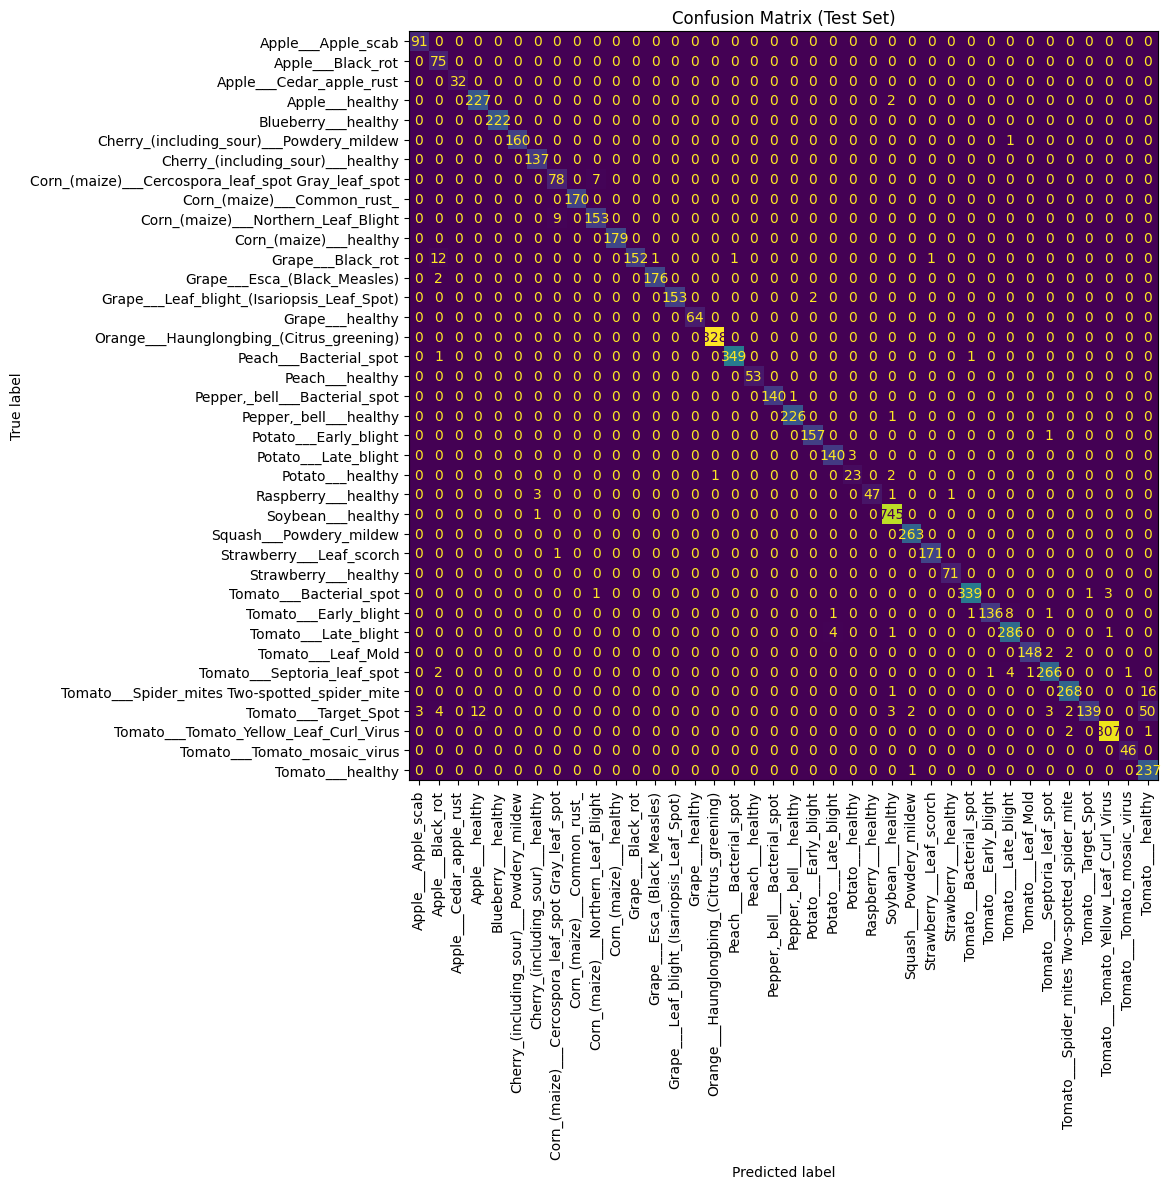

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(test_targets, test_preds)
fig, ax = plt.subplots(figsize=(15, 12)) # Increased figure size
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=class_names)
cmd.plot(ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

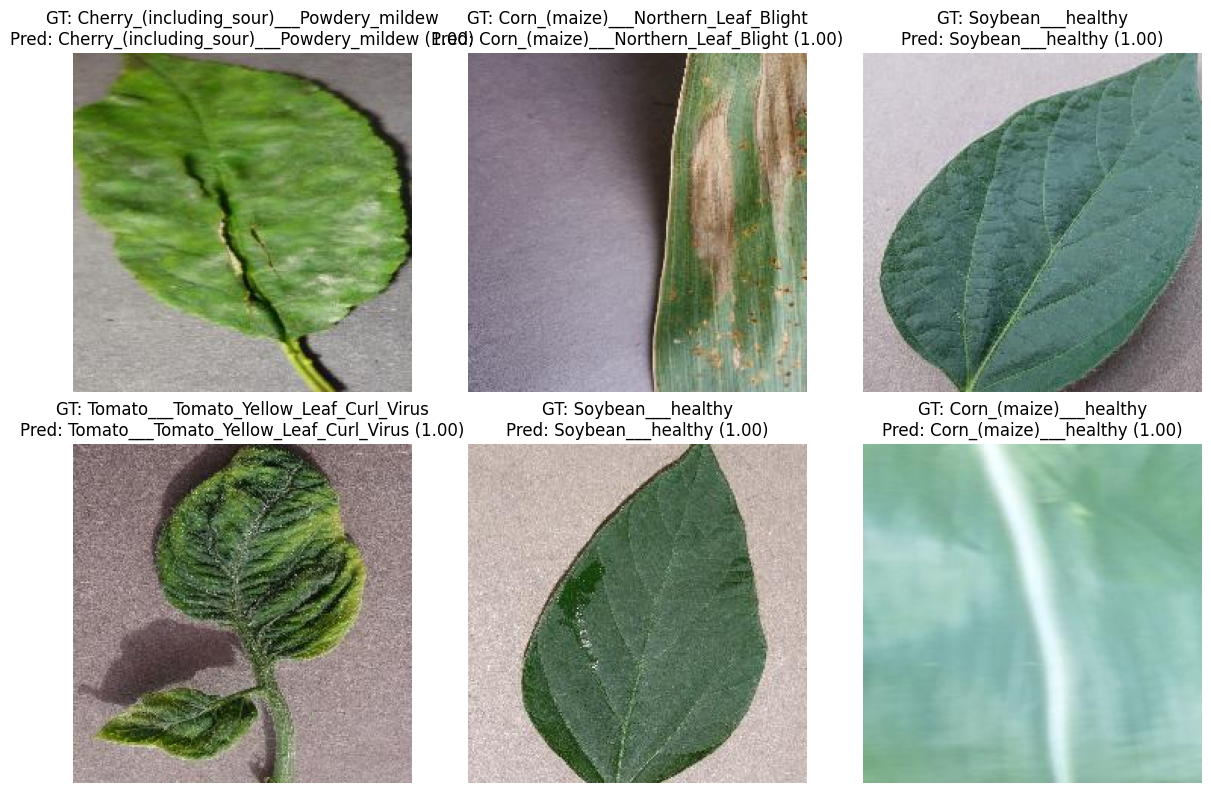

In [ ]:
model.eval()
sample_images, sample_labels = next(iter(dataloaders["test"]))
with torch.no_grad():
    outputs = model(sample_images.to(DEVICE))
    probs = torch.softmax(outputs, dim=1)
    sample_preds = probs.argmax(dim=1).cpu()

mean_tensor = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
std_tensor = torch.tensor(IMAGENET_STD).view(3, 1, 1)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    if idx >= len(sample_images):
        ax.axis("off")
        continue
    image = sample_images[idx] * std_tensor + mean_tensor
    image = image.clamp(0, 1)
    ax.imshow(image.permute(1, 2, 0).numpy())
    true_label = class_names[sample_labels[idx].item()]
    pred_label = class_names[sample_preds[idx].item()]
    confidence = probs[idx, sample_preds[idx]].item()
    ax.set_title(f"GT: {true_label}\nPred: {pred_label} ({confidence:.2f})")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 7. Additional Architectures
The baseline fine-tunes a ResNet-18. Run the optional cells below to try other pretrained models and compare their evaluation metrics.

In [ ]:
from typing import Callable, Dict
import copy
import pandas as pd
from sklearn.metrics import confusion_matrix

def build_resnet34(num_classes: int) -> nn.Module:
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

def build_densenet121(num_classes: int) -> nn.Module:
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(DEVICE)

def build_efficientnet_b0(num_classes: int) -> nn.Module:
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model.to(DEVICE)

ADDITIONAL_MODEL_BUILDERS: Dict[str, Callable[[int], nn.Module]] = {
    "ResNet34": build_resnet34,
    "DenseNet121": build_densenet121,
    "EfficientNet_B0": build_efficientnet_b0,
}

print(f"Additional architectures available: {list(ADDITIONAL_MODEL_BUILDERS)}")

Additional architectures available: ['ResNet34', 'DenseNet121', 'EfficientNet_B0']


In [ ]:
import random
from sklearn.metrics import classification_report

def train_additional_model(
    model_name: str,
    builder: Callable[[int], nn.Module],
    *,
    epochs: int = EPOCHS,
    learning_rate: float = LEARNING_RATE,
) -> Dict[str, object]:
    print(f"\n=== {model_name}: starting {epochs} epoch run ===")
    torch.manual_seed(SEED)
    random.seed(SEED)
    if DEVICE.type == "cuda":
        torch.cuda.manual_seed_all(SEED)

    model = builder(len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history_rows: List[Dict[str, float]] = []
    best_state = None
    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, dataloaders["train"], criterion, optimizer)
        val_loss, val_acc, _, _ = evaluate(
            model,
            dataloaders["val"],
            criterion,
            desc=f"{model_name} Validate",
        )
        history_rows.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
            }
        )
        print(
            f"{model_name} | Epoch {epoch}/{epochs} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}"
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc, test_preds, test_targets = evaluate(
        model,
        dataloaders["test"],
        criterion,
        desc=f"{model_name} Test",
    )

    report_dict = classification_report(
        test_targets,
        test_preds,
        target_names=class_names,
        digits=4,
        output_dict=True,
        zero_division=0,
    )
    report_df = pd.DataFrame(report_dict).transpose()
    report_text = classification_report(
        test_targets,
        test_preds,
        target_names=class_names,
        digits=4,
        zero_division=0,
    )
    conf_mat = confusion_matrix(test_targets, test_preds)

    return {
        "name": model_name,
        "history": history_rows,
        "best_val_acc": best_val_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "report_df": report_df,
        "report_text": report_text,
        "confusion_matrix": conf_mat,
        "preds": test_preds,
        "targets": test_targets,
    }

In [ ]:
from IPython.display import display

**Additional architectures : ['ResNet34', 'DenseNet121', 'EfficientNet_B0']**

In [ ]:
# Edit the list below if you want to try a subset of the additional models
models_to_run = list(ADDITIONAL_MODEL_BUILDERS.keys())

comparison_results = []
for model_name in models_to_run:
    result = train_additional_model(model_name, ADDITIONAL_MODEL_BUILDERS[model_name])
    comparison_results.append(result)

if comparison_results:
    comparison_summary = pd.DataFrame(
        [
            {
                "model": res["name"],
                "best_val_acc": res["best_val_acc"],
                "test_acc": res["test_acc"],
                "test_loss": res["test_loss"],
            }
            for res in comparison_results
        ]
    )
    comparison_summary = comparison_summary.sort_values("test_acc", ascending=False).reset_index(drop=True)
    display(comparison_summary)
else:
    print("No additional models have been trained yet.")


=== ResNet34: starting 10 epoch run ===
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 197MB/s]


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 1/10 | train_acc=0.8686 val_acc=0.9478


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 2/10 | train_acc=0.9286 val_acc=0.9503


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 3/10 | train_acc=0.9432 val_acc=0.9783


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 4/10 | train_acc=0.9485 val_acc=0.9654


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 5/10 | train_acc=0.9541 val_acc=0.9837


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 6/10 | train_acc=0.9593 val_acc=0.9817


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 7/10 | train_acc=0.9614 val_acc=0.9705


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 8/10 | train_acc=0.9626 val_acc=0.9844


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 9/10 | train_acc=0.9670 val_acc=0.9882


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

ResNet34 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet34 | Epoch 10/10 | train_acc=0.9699 val_acc=0.9772


ResNet34 Test:   0%|          | 0/255 [00:00<?, ?it/s]


=== DenseNet121: starting 10 epoch run ===
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 1/10 | train_acc=0.9012 val_acc=0.9727


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 2/10 | train_acc=0.9548 val_acc=0.9774


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 3/10 | train_acc=0.9631 val_acc=0.9844


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 4/10 | train_acc=0.9672 val_acc=0.9882


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 5/10 | train_acc=0.9707 val_acc=0.9817


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 6/10 | train_acc=0.9716 val_acc=0.9912


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 7/10 | train_acc=0.9757 val_acc=0.9891


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 8/10 | train_acc=0.9744 val_acc=0.9909


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 9/10 | train_acc=0.9754 val_acc=0.9818


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

DenseNet121 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

DenseNet121 | Epoch 10/10 | train_acc=0.9790 val_acc=0.9817


DenseNet121 Test:   0%|          | 0/255 [00:00<?, ?it/s]


=== EfficientNet_B0: starting 10 epoch run ===
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 1/10 | train_acc=0.8925 val_acc=0.9862


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 2/10 | train_acc=0.9567 val_acc=0.9902


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 3/10 | train_acc=0.9658 val_acc=0.9914


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 4/10 | train_acc=0.9706 val_acc=0.9890


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 5/10 | train_acc=0.9727 val_acc=0.9843


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 6/10 | train_acc=0.9759 val_acc=0.9942


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 7/10 | train_acc=0.9770 val_acc=0.9883


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 8/10 | train_acc=0.9780 val_acc=0.9912


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 9/10 | train_acc=0.9792 val_acc=0.9885


Train:   0%|          | 0/1188 [00:00<?, ?it/s]

EfficientNet_B0 Validate:   0%|          | 0/255 [00:00<?, ?it/s]

EfficientNet_B0 | Epoch 10/10 | train_acc=0.9803 val_acc=0.9931


EfficientNet_B0 Test:   0%|          | 0/255 [00:00<?, ?it/s]

,model,best_val_acc,test_acc,test_loss
0,EfficientNet_B0,0.994230,0.992511,0.023549
1,DenseNet121,0.991160,0.991037,0.025401
2,ResNet34,0.988214,0.988705,0.035261


In [ ]:
# Set to the model you want to inspect in detail (e.g., "DenseNet121")
selected_model_name = None

if not comparison_results:
    raise RuntimeError("Run the additional model training cell above before inspecting results.")

available_models = [res["name"] for res in comparison_results]
if selected_model_name is None:
    selected_model_name = available_models[0]
elif selected_model_name not in available_models:
    raise ValueError(f"selected_model_name must be one of {available_models}")

selected_result = next(res for res in comparison_results if res["name"] == selected_model_name)
print(f"Inspecting results for: {selected_model_name}")
selected_result["report_df"].round({"precision": 4, "recall": 4, "f1-score": 4})

Inspecting results for: ResNet34


,precision,recall,f1-score,support
Apple___Apple_scab,1.0000,0.9890,0.9945,91.000000
Apple___Black_rot,1.0000,1.0000,1.0000,75.000000
Apple___Cedar_apple_rust,0.9697,1.0000,0.9846,32.000000
Apple___healthy,0.9869,0.9869,0.9869,229.000000
Blueberry___healthy,0.9955,1.0000,0.9978,222.000000
Cherry_(including_sour)___Powdery_mildew,1.0000,0.9938,0.9969,161.000000
Cherry_(including_sour)___healthy,0.9716,1.0000,0.9856,137.000000
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.8864,0.9176,0.9017,85.000000
Corn_(maize)___Common_rust_,1.0000,1.0000,1.0000,170.000000
Corn_(maize)___Northern_Leaf_Blight,0.9560,0.9383,0.9470,162.000000


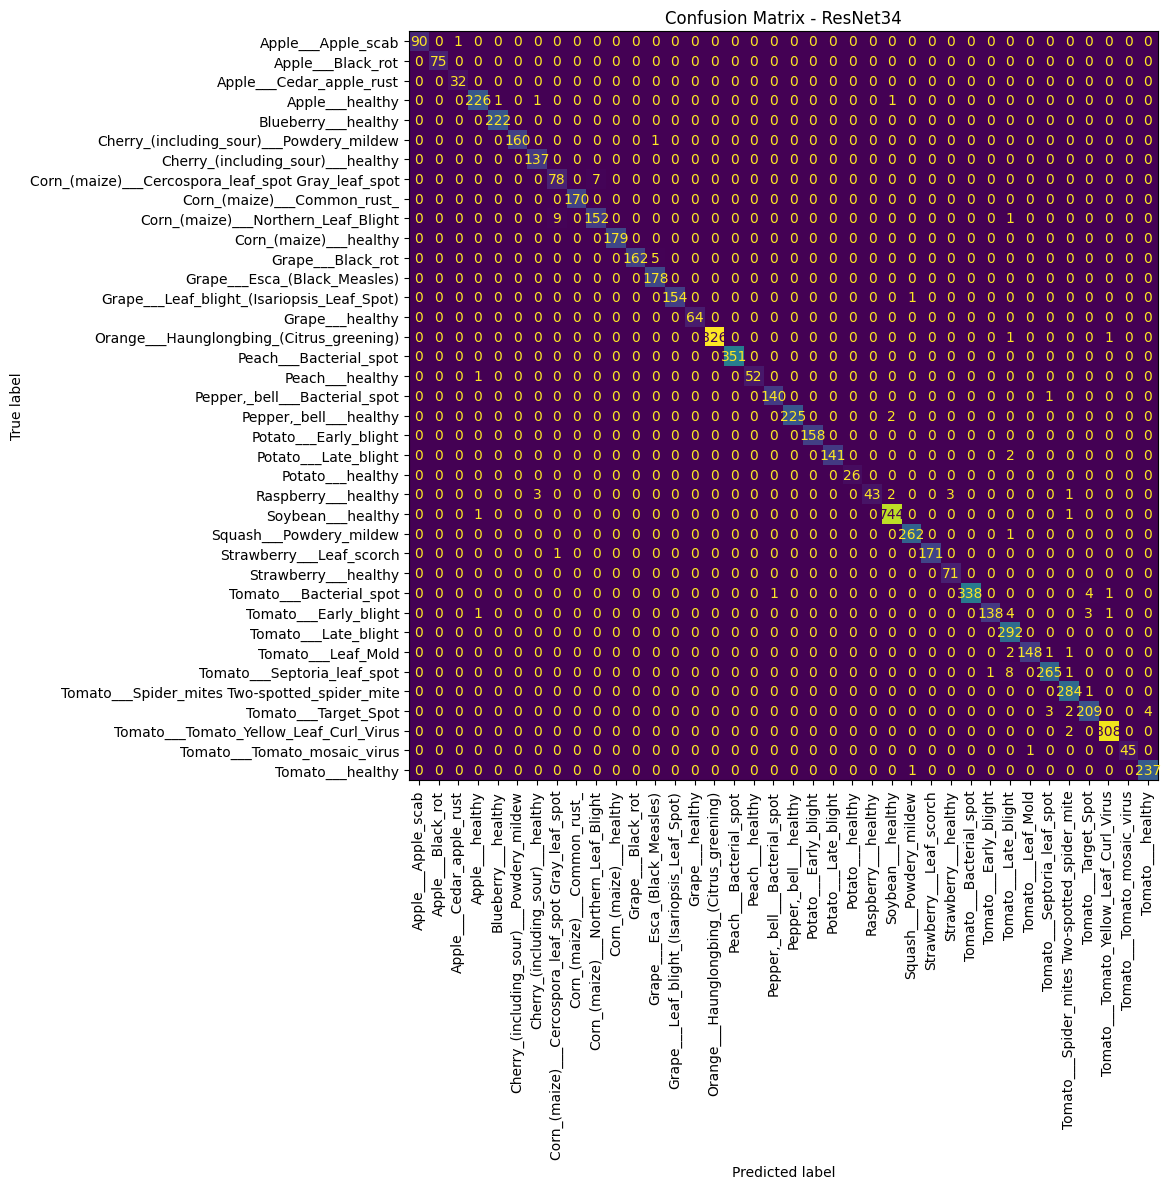

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(selected_result["confusion_matrix"], display_labels=class_names)
fig, ax = plt.subplots(figsize=(15, 12)) # Increased figure size
cmd.plot(ax=ax, xticks_rotation=90, colorbar=False)
ax.set_title(f"Confusion Matrix - {selected_model_name}")
plt.tight_layout()
plt.show()

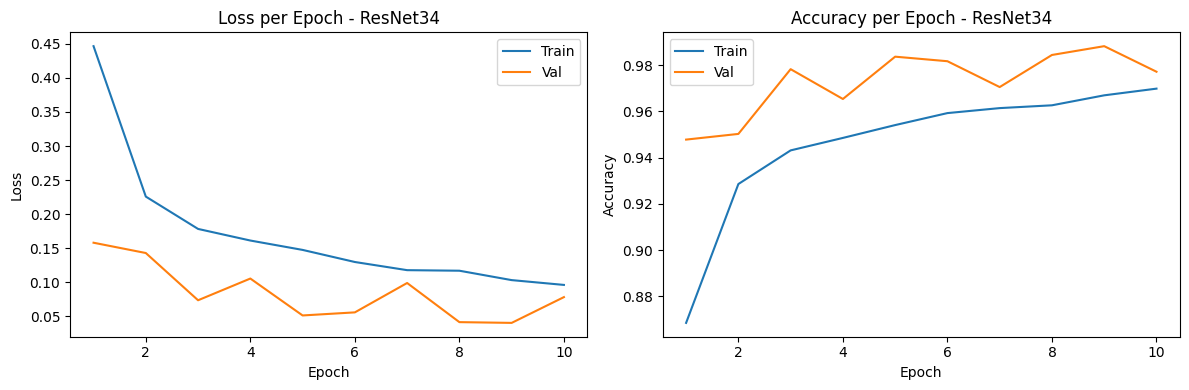

In [ ]:
selected_history_df = pd.DataFrame(selected_result["history"])
if selected_history_df.empty:
    raise RuntimeError("No training history captured for the selected model.")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axes[0].plot(selected_history_df["epoch"], selected_history_df["train_loss"], label="Train")
axes[0].plot(selected_history_df["epoch"], selected_history_df["val_loss"], label="Val")
axes[0].set_title(f"Loss per Epoch - {selected_model_name}")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(selected_history_df["epoch"], selected_history_df["train_acc"], label="Train")
axes[1].plot(selected_history_df["epoch"], selected_history_df["val_acc"], label="Val")
axes[1].set_title(f"Accuracy per Epoch - {selected_model_name}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Best accuracy results for each model:")
for res in comparison_results:
    print(f"- {res['name']}: Best Validation Accuracy = {res['best_val_acc']:.4f}, Test Accuracy = {res['test_acc']:.4f}")

Best accuracy results for each model:
- ResNet34: Best Validation Accuracy = 0.9882, Test Accuracy = 0.9887
- DenseNet121: Best Validation Accuracy = 0.9912, Test Accuracy = 0.9910
- EfficientNet_B0: Best Validation Accuracy = 0.9942, Test Accuracy = 0.9925


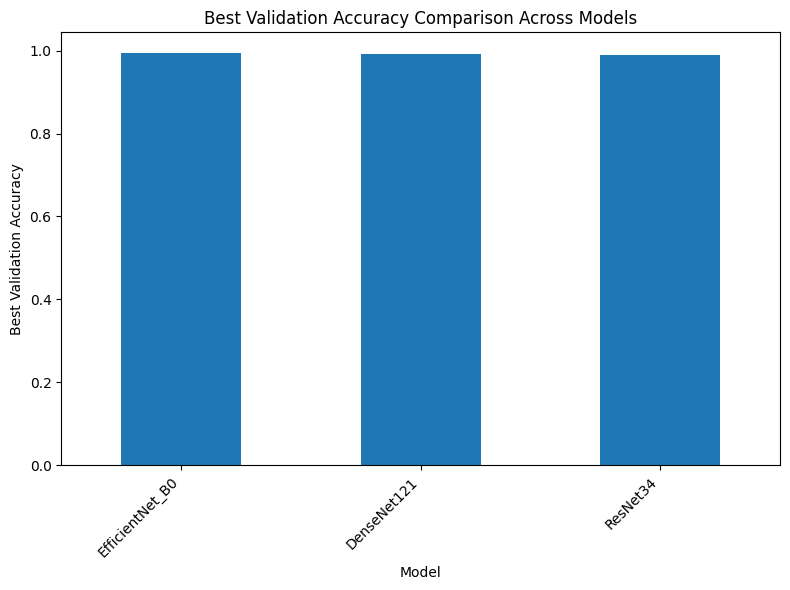

In [ ]:
import matplotlib.pyplot as plt

if 'comparison_summary' not in locals() or comparison_summary.empty:
    print("comparison_summary DataFrame is not available or empty.")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    comparison_summary.plot(x='model', y='best_val_acc', kind='bar', ax=ax, legend=False)
    ax.set_title("Best Validation Accuracy Comparison Across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Best Validation Accuracy")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

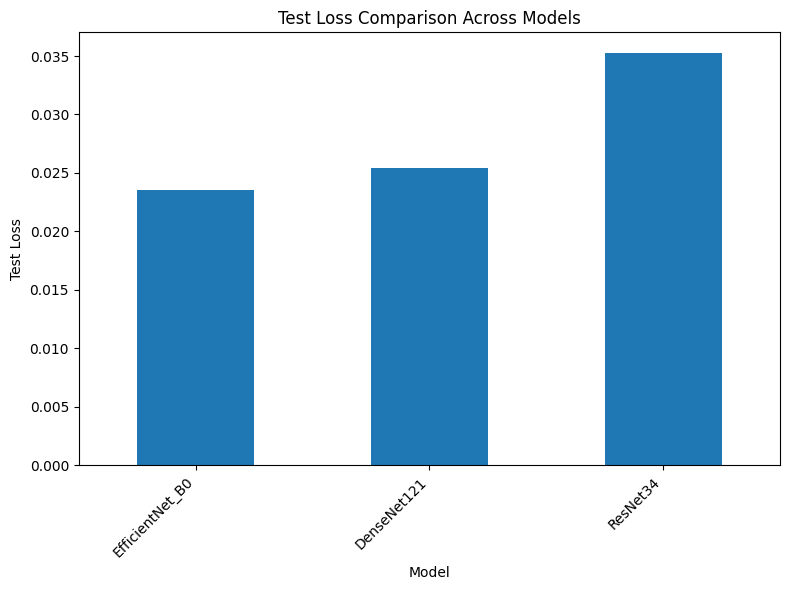

In [ ]:
import matplotlib.pyplot as plt

if 'comparison_summary' not in locals() or comparison_summary.empty:
    print("comparison_summary DataFrame is not available or empty.")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    comparison_summary.plot(x='model', y='test_loss', kind='bar', ax=ax, legend=False)
    ax.set_title("Test Loss Comparison Across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Test Loss")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
display(comparison_summary)

,model,best_val_acc,test_acc,test_loss
0,EfficientNet_B0,0.994230,0.992511,0.023549
1,DenseNet121,0.991160,0.991037,0.025401
2,ResNet34,0.988214,0.988705,0.035261


##  Save Artifacts

In [ ]:
save_artifacts(
    output_dir=DATASET_ROOT / "simple_runs",
    args_dict={
        "dataset_root": str(DATASET_ROOT),
        "subset": SUBSET,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "val_split": VAL_SPLIT,
        "test_split": TEST_SPLIT,
        "limit_per_class": LIMIT_PER_CLASS,
        "learning_rate": LEARNING_RATE,
        "seed": SEED,
    },
    model_state=model.state_dict(),
    report_text=report_text,
)

Artifacts saved to plantvillage_data/simple_runs
